In [1]:
!pip install wandb


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importing required libraries
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
# Initialize Weights & Biases
wandb.init(project="iris_mlp", name="experiment_1_new", config={
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 400,
    "hidden_layer_size": 16,
    "architecture": [
        {"layer": "Input", "units": 4},
        {"layer": "Dense", "units": 16, "activation": "relu"},
        {"layer": "Dense", "units": 3, "activation": "softmax"}
    ]
})

config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: darpana (darpana-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
# Load the Iris dataset
data = load_iris()
X = data.data  # Features
y = data.target.reshape(-1, 1)  # Labels

In [ ]:
# One Hot Encoding
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y)

In [6]:
# Split dataset into train (70%), validation (10%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_one_hot, test_size=0.3, random_state=42, stratify=y_one_hot)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

# Print dataset shapes to confirm percentage split
print(f"Original dataset shape: {X.shape}")
print(f"Train set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Original dataset shape: (150, 4)
Train set shape: (105, 4), (105, 3)
Validation set shape: (15, 4), (15, 3)
Test set shape: (30, 4), (30, 3)


In [7]:
# Normalize feature values using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [9]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size=4, hidden_size=16, output_size=3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [10]:
# Instantiate the model
model = MLP()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

In [11]:
# Training loop
train_losses, val_losses = [], []
for epoch in range(config.epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    # Store losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Log losses to W&B
    wandb.log({"Train Loss": loss.item(), "Validation Loss": val_loss.item(), "Epoch": epoch + 1})

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{config.epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [20/400], Train Loss: 1.0723, Val Loss: 1.0673
Epoch [40/400], Train Loss: 1.0424, Val Loss: 1.0394
Epoch [60/400], Train Loss: 1.0085, Val Loss: 1.0079
Epoch [80/400], Train Loss: 0.9683, Val Loss: 0.9703
Epoch [100/400], Train Loss: 0.9235, Val Loss: 0.9287
Epoch [120/400], Train Loss: 0.8787, Val Loss: 0.8885
Epoch [140/400], Train Loss: 0.8387, Val Loss: 0.8546
Epoch [160/400], Train Loss: 0.8058, Val Loss: 0.8279
Epoch [180/400], Train Loss: 0.7793, Val Loss: 0.8075
Epoch [200/400], Train Loss: 0.7579, Val Loss: 0.7931
Epoch [220/400], Train Loss: 0.7408, Val Loss: 0.7830
Epoch [240/400], Train Loss: 0.7271, Val Loss: 0.7751
Epoch [260/400], Train Loss: 0.7154, Val Loss: 0.7680
Epoch [280/400], Train Loss: 0.7051, Val Loss: 0.7613
Epoch [300/400], Train Loss: 0.6956, Val Loss: 0.7546
Epoch [320/400], Train Loss: 0.6866, Val Loss: 0.7479
Epoch [340/400], Train Loss: 0.6781, Val Loss: 0.7409
Epoch [360/400], Train Loss: 0.6698, Val Loss: 0.7337
Epoch [380/400], Train Loss: 0.6

In [12]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test)
    test_loss = criterion(y_pred_probs, y_test)  
    y_pred = torch.argmax(y_pred_probs, axis=1)
    y_true = torch.argmax(y_test, axis=1)

In [13]:
# Compute performance metrics
y_pred, y_true = y_pred.numpy(), y_true.numpy()
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print evaluation results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Loss: 0.6360
Test Accuracy: 0.9667


Test Precision: 0.9697
Test Recall: 0.9667
Test F1 Score: 0.9666


In [14]:
# Log final evaluation metrics to Weights & Biases
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
})

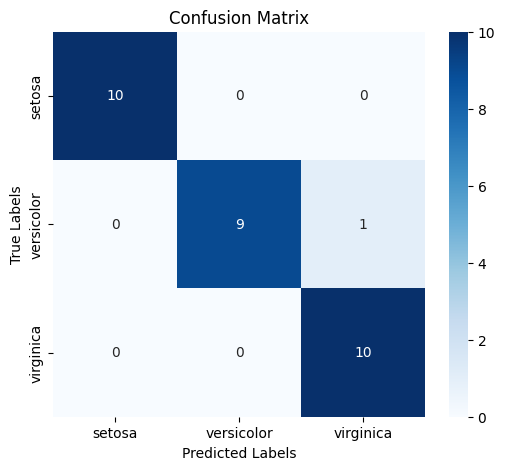

In [15]:
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

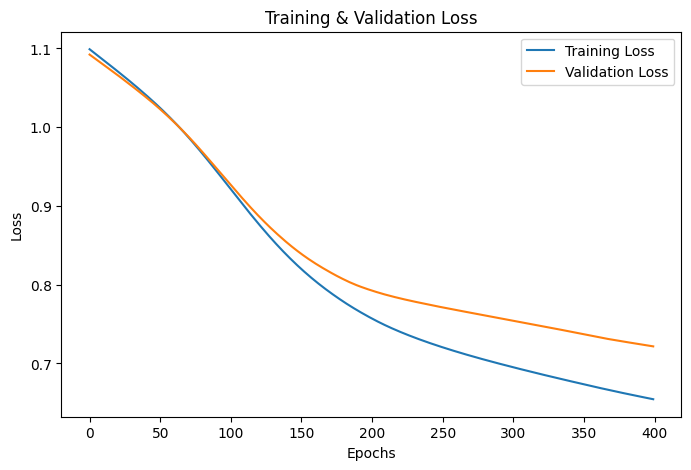

In [16]:
# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')  
plt.plot(val_losses, label='Validation Loss')  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

# Log loss curve to Weights & Biases (W&B)
wandb.log({"loss_curves": wandb.Image(plt)})

plt.show()

In [17]:
# Finish W&B run
wandb.finish()

Epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
Train Loss,█████▇▇▇▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Validation Loss,███▇▇▇▇▇▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
f1_score,▁
precision,▁
recall,▁
test_accuracy,▁
test_loss,▁
Epoch,400
Train Loss,0.65459
Validation Loss,0.72171
